In [116]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from itertools import product

#change working directory
os.chdir("/Users/xudanglan/Desktop/ml/hw2/")

#load data
bike_train = pd.read_csv("Bike_train.csv")
bike_test = pd.read_csv("Bike_test.csv")


## Explore the data before modeling

relationship between *count* and *windspeed*, *humidity*, *temp*, and *atemp*.

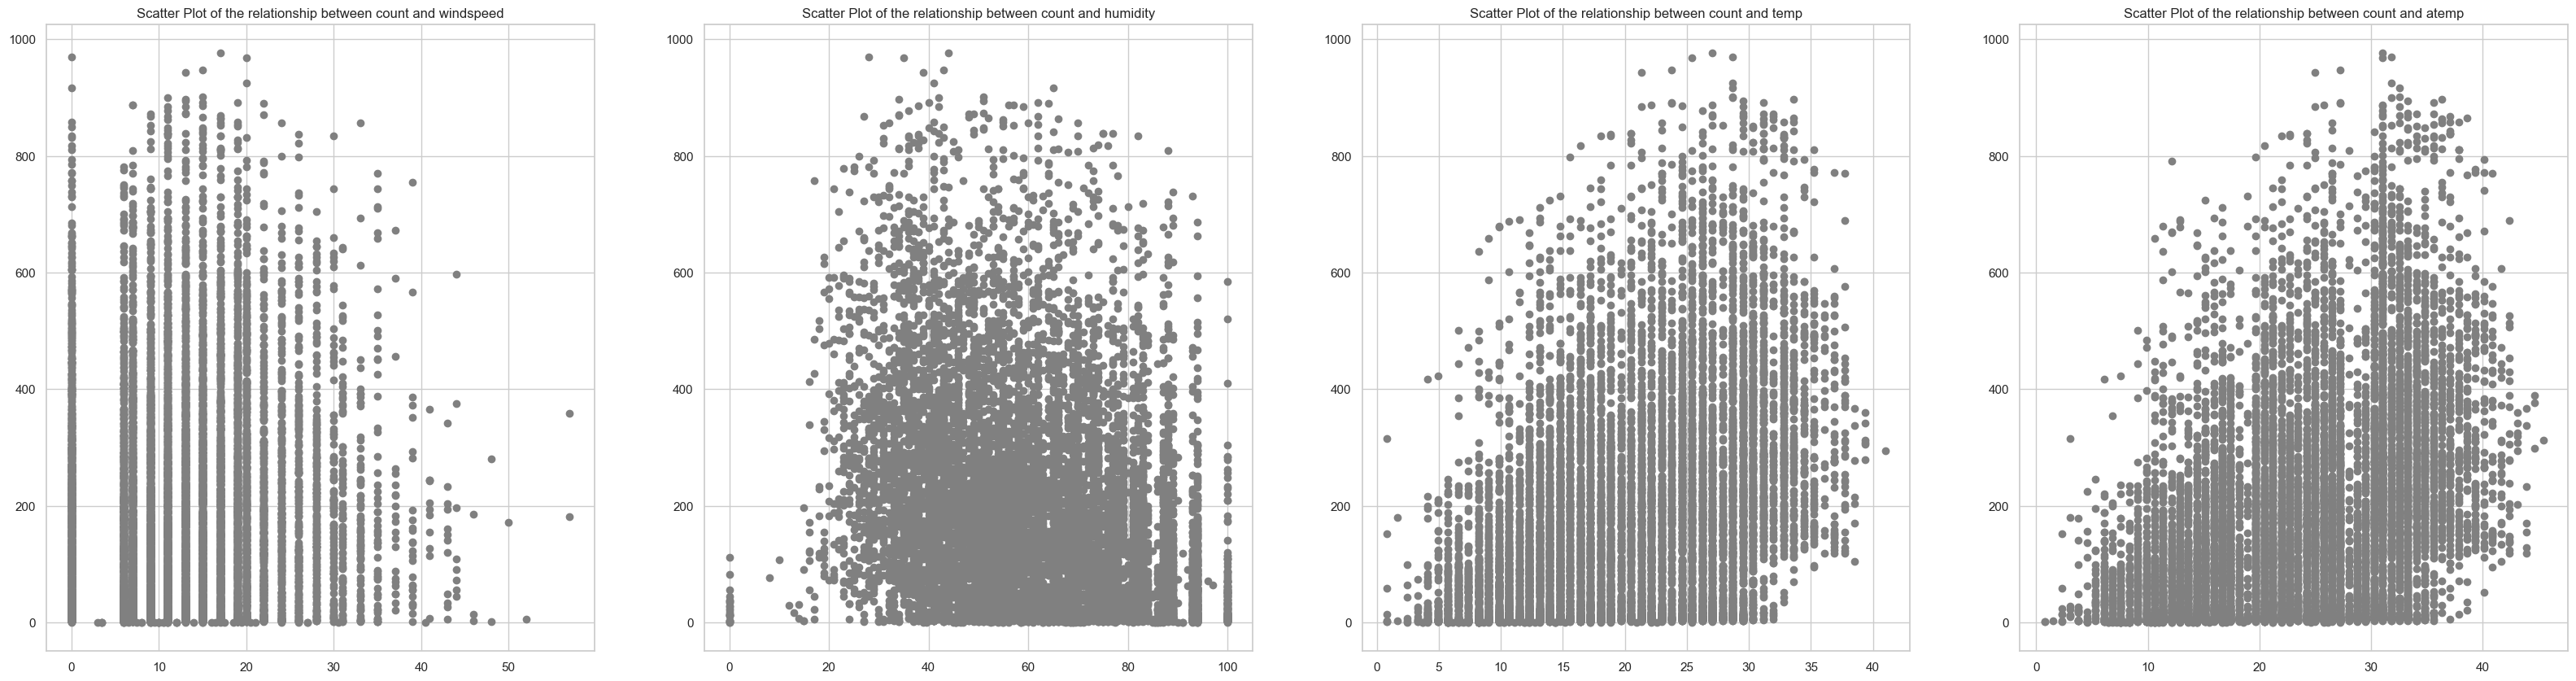

In [120]:
fig,(ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(40, 10))
ax1.scatter(bike_train['windspeed'], bike_train['count'], color='grey')
ax1.set_title("Scatter Plot of the relationship between count and windspeed")


ax2.scatter(bike_train['humidity'], bike_train['count'], color='grey')
ax2.set_title("Scatter Plot of the relationship between count and humidity")


ax3.scatter(bike_train['temp'], bike_train['count'], color='grey')
ax3.set_title("Scatter Plot of the relationship between count and temp")


ax4.scatter(bike_train['atemp'], bike_train['count'], color='grey')
ax4.set_title("Scatter Plot of the relationship between count and atemp")

plt.show()


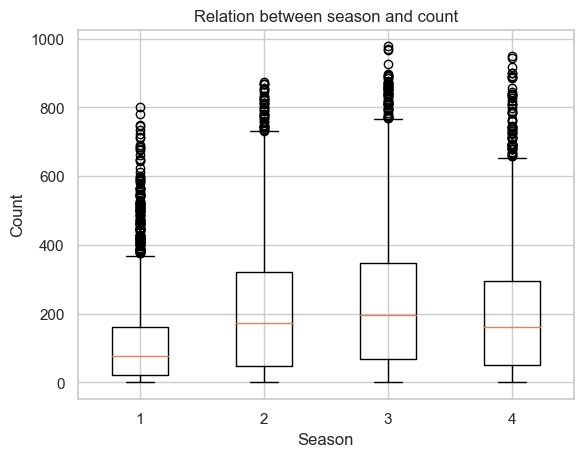

In [58]:
#relation between season and count
plt.boxplot([bike_train.loc[bike_train['season']==i, 'count'] for i in range(1,5)])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Relation between season and count')
plt.xticks(range(1,5), ['1', '2', '3', '4'])
plt.show()


__Conclusion__: Summer has the highest average of bike rental counts, followed by spring and fall. The average count appears to be the smallest in winter.

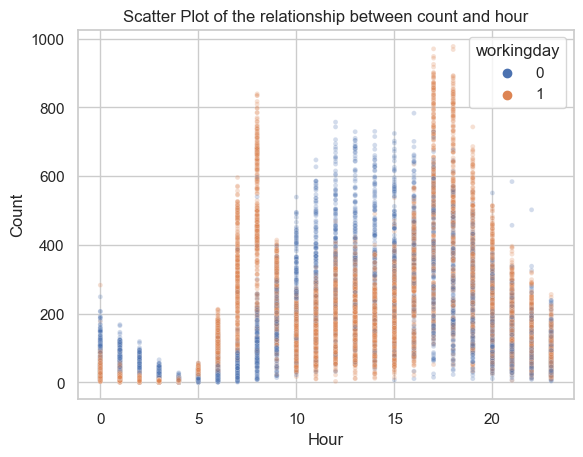

In [59]:
sns.scatterplot(data=bike_train, x="hour", y="count", hue="workingday", s = 12,  alpha=0.25)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Scatter Plot of the relationship between count and hour')
plt.show()


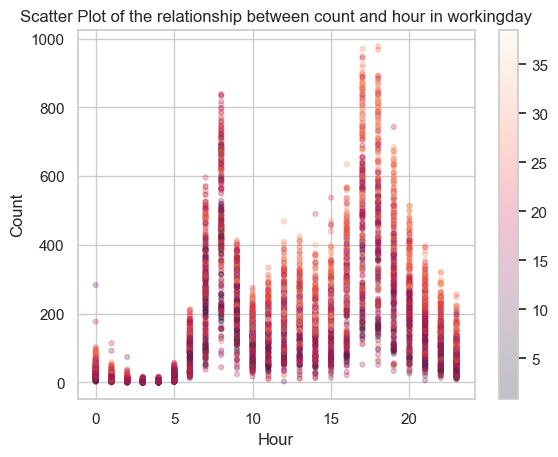

In [60]:
workingday = bike_train[bike_train['workingday'] == 1]
plt.scatter(workingday['hour'], workingday['count'], c=workingday['temp'], s = 12,alpha=0.25)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Scatter Plot of the relationship between count and hour in workingday')
plt.colorbar()

plt.show()

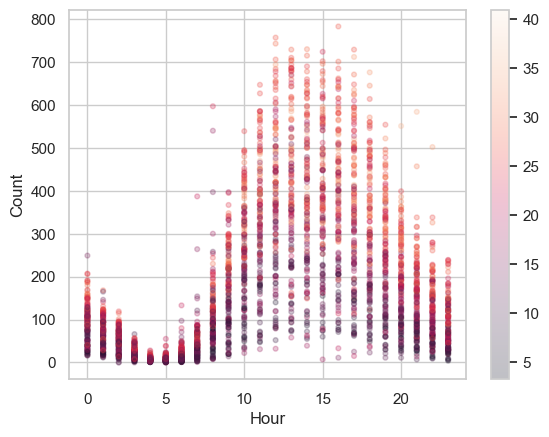

In [61]:
nonworkingday = bike_train[bike_train['workingday'] == 0]
plt.scatter(nonworkingday["hour"],nonworkingday['count'],c = nonworkingday["temp"],s = 12, alpha=0.25)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.colorbar()
plt.show()

__Conclusion__: Generally speaking(figure.1.), *count* remains high during the daytime with two peaks at 8am and 17pm. It depends on whether it is a *workingday*. During working day(figure.2.) *count* presented a concave shape during daytime with the same two peaks as in figure.1. During non working day(figure.3.), *count* increases from morning to noon, keeps high during the afternoon and decreases from about 17pm till midnight and early morning.

By coloring the scatterplot using temperature, we observe that the temperature will affect hourly number of rentals: low temperatures will hinder people from renting bike. People tend to rent bike under a higher temperature.

Model part

## 1. Deal with strange weather value

When filter *weather*, we find that there exists strange value of *weather*, such as 1.5 and 2.5. So we choose to round up and replace them with 2 and 3 respectively.


In [74]:
bike_train['weather'] = np.where(bike_train['weather'] == 1.5, 2, bike_train['weather'])
bike_train['weather'] = np.where(bike_train['weather'] == 2.5, 3, bike_train['weather'])



For abnormal humidity & atemp: make average for abnormal humidity & atemp by hours between records from the day before and after

In [75]:
for i in range(24):
    bike_train.loc[(bike_train['daylabel'] == 69) & (bike_train['hour'] == i), 'humidity'] = (bike_train.loc[(bike_train['daylabel'] == 68) & (bike_train['hour'] == i), 'humidity'].values[0] + bike_train.loc[(bike_train['daylabel'] == 70) & (bike_train['hour'] == i), 'humidity'].values[0]) / 2
    bike_train.loc[(bike_train['daylabel'] == 595) & (bike_train['hour'] == i), 'atemp'] = (bike_train.loc[(bike_train['daylabel'] == 596) & (bike_train['hour'] == i), 'atemp'].values[0] + bike_train.loc[(bike_train['daylabel'] == 597) & (bike_train['hour'] == i), 'atemp'].values[0]) / 2

In [76]:
#drop outlier
bike_train.loc[(bike_train["daylabel"] == 184) & (bike_train["hour"].isin([17, 18])), "windspeed"] = np.nan
bike_train.dropna(inplace=True)



## 4. Unusual workingday & holiday

We find that there appears several outliers to have extremely high count around 8pm, which is not that normal for "holiday".

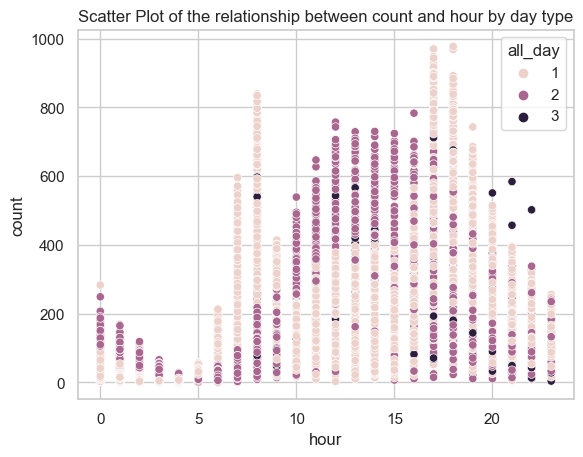

In [81]:
# create new column "all_day" based on "holiday" and "workingday" columns
bike_train["all_day"] = np.where(bike_train["holiday"]==1, 3, np.where(bike_train["workingday"]==1, 1, 2))

# create scatter plot
sns.scatterplot(data=bike_train, x="hour", y="count", hue="all_day")
plt.title("Scatter Plot of the relationship between count and hour by day type")
plt.show()

#drop all_day column for the consistency to test dataset
bike_train = bike_train.drop(columns=['all_day'])



So we pick them up and find several crucial date: Sep 15th, Oct 10th and Apr 16th in 2012. They are tagged as holiday but they demonstrate a working day pattern in the plot.

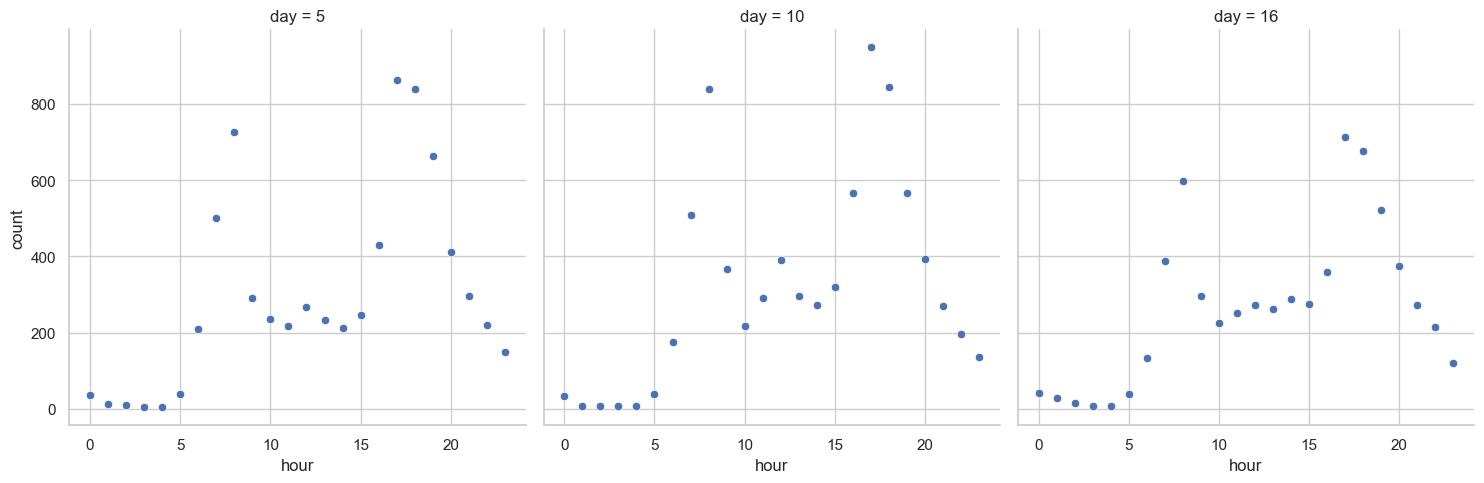

In [83]:
# Filter the data
filtered_date = bike_train[(bike_train.year == 2012) & (((bike_train.month == 9)&(bike_train.day == 5)) | ((bike_train.month == 10)&(bike_train.day == 10) ) | ((bike_train.month == 4)&  (bike_train.day == 16)))]

# Create the faceted plot
sns.relplot(data=filtered_date, x='hour', y='count', col='day')

So we changed the tag of these date from *holiday* to *workingday*.

In [84]:
bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 10) & (bike_train["day"] == 10), "workingday"] = 1
bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 10) & (bike_train["day"] == 10), "holiday"] = 0

bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 9) & (bike_train["day"] == 5), "workingday"] = 1
bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 9) & (bike_train["day"] == 5), "holiday"] = 0

bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 4) & (bike_train["day"] == 16), "workingday"] = 1
bike_train.loc[(bike_train["year"] == 2012) & (bike_train["month"] == 4) & (bike_train["day"] == 16), "holiday"] = 0


## 5. Transform daylabel to weekday

After finding certain holiday to have same pattern of working day, we then came up with idea that every working day might have different traits. For example, people may feel more casual on friday and thus rent more bike. So we add a column named *weekday* to see if they have any special.


In [85]:
bike_train['weekday'] = (bike_train['daylabel'] - 3) % 7 + 1
bike_train.drop(['daylabel'], axis=1, inplace=True)

bike_test['weekday'] = (bike_test['daylabel'] - 3) % 7 + 1
bike_test.drop(['daylabel'], axis=1, inplace=True)

Then we draw seven plots from Monday(1) to Sunday(7):

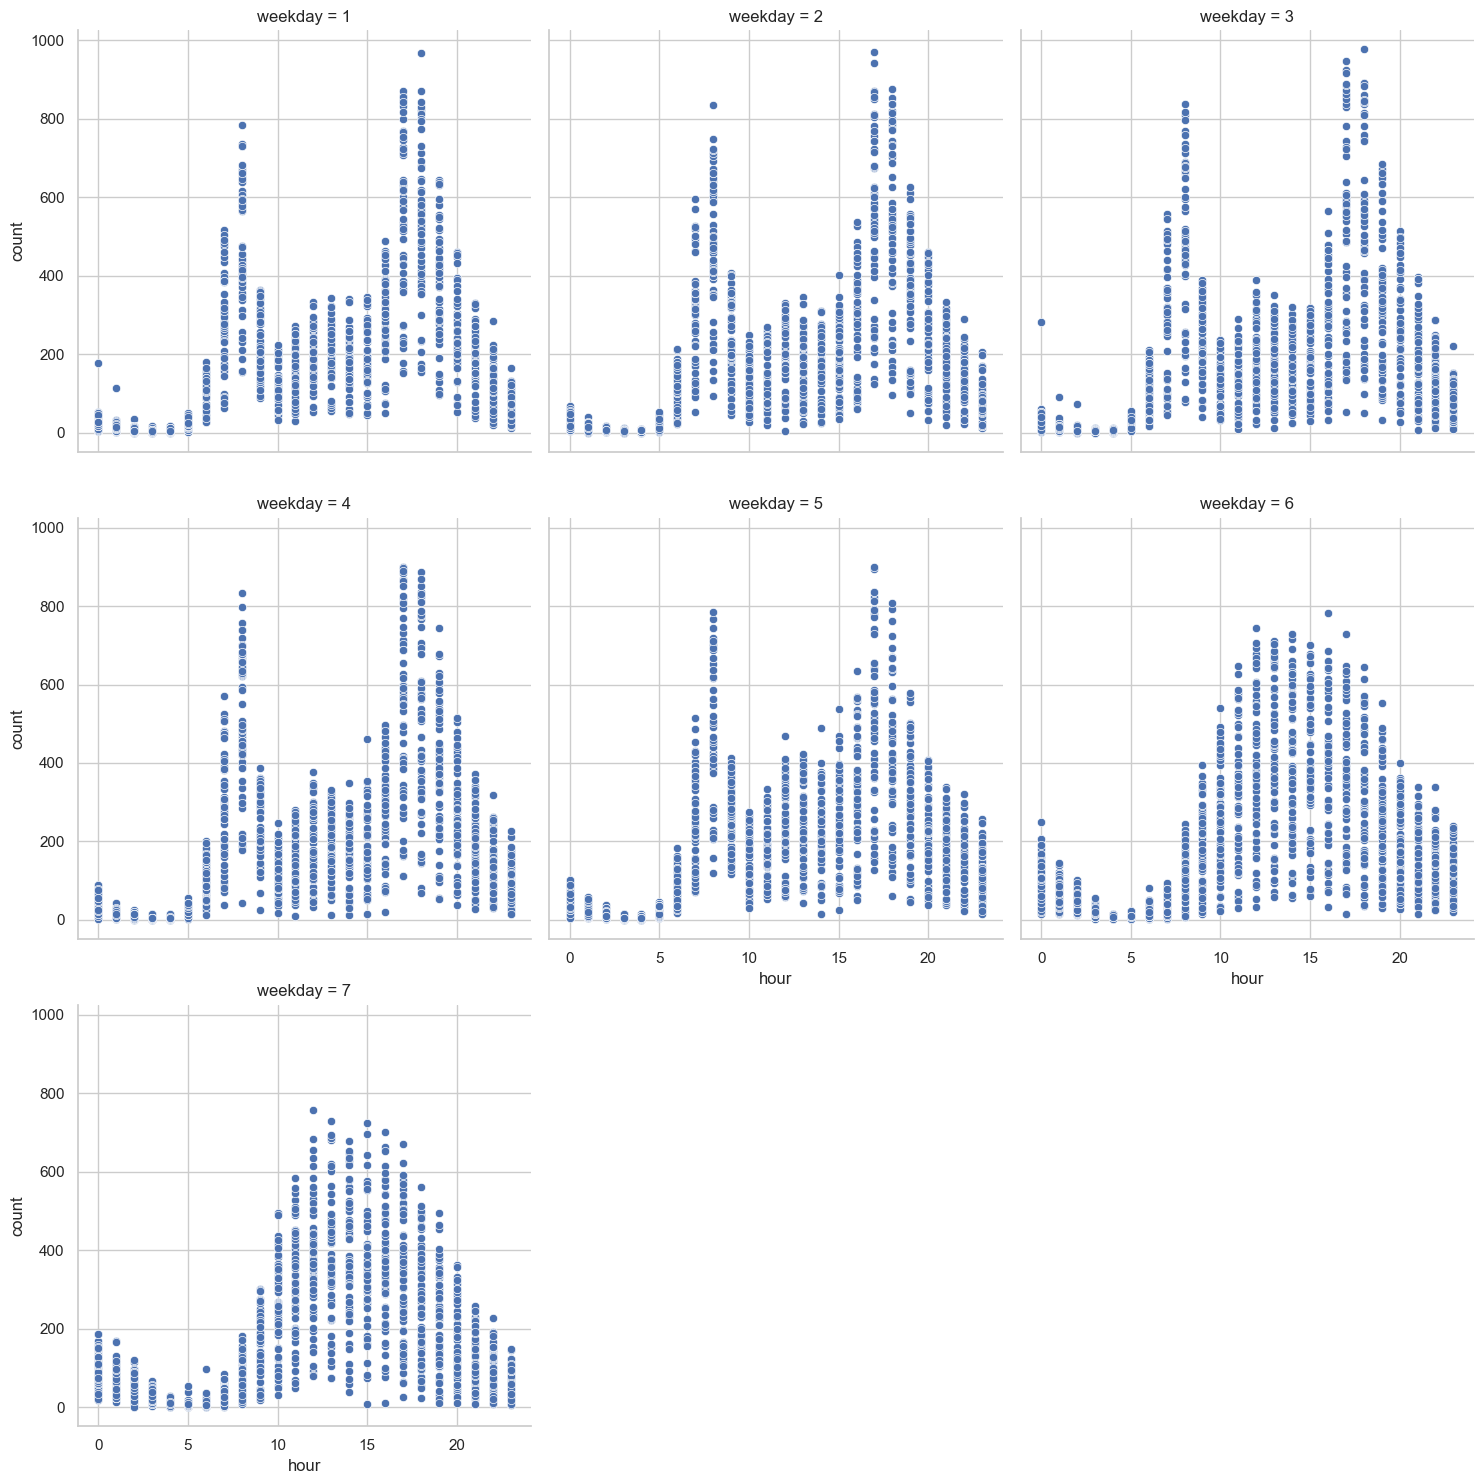

In [86]:
sns.set(style="whitegrid")
sns.relplot(x="hour", y="count", col="weekday", col_wrap=3, data=bike_train[bike_train['holiday'] == 0])

We can easily oberve that two weekends day follow the exact pattern just like in Q2.c. However, weekdays, though sharing quite similar shape, Monday seems to have higher peak and lower concave part while Friday is lean to the weekend pattern. So we decide to add *weekday* as a new variable and drop *daylabel* because it does not offer any information.

We check the correlationship between variables. Although some of them are highly correlated such as *temp* and *atemp*, but we decide not to do the feature selection because the total variable are not too large and we found little change in RMSE by doing feature selection.

<Axes: >

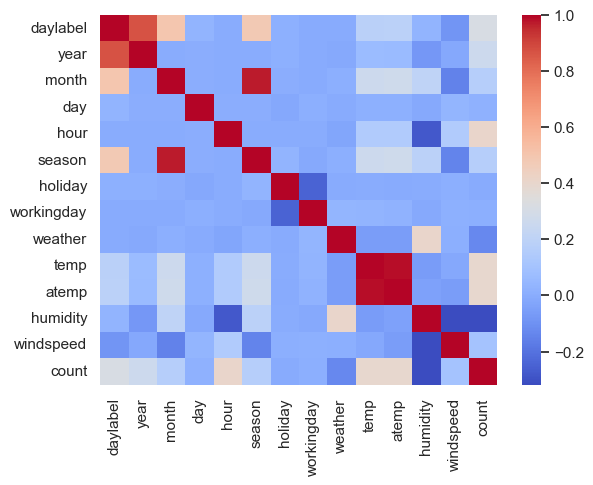

In [122]:
# get the correlation matrix
corr_matrix = bike_train.corr()

# plot the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm')

## 6. Transform year, month, season, weather into dummies

When exploring the data, we also find out that there are some categorical variables, which should be transform into dummy variables when running the models. So we choose to transform *year*, *month*, *season*, *weather* into dummies. The reason why we don't transform *hour* is because it will significantly decrease the speed of running the model. And we can also interpret *hour* as a numeric variable. For example, 0.5 hour means 30 minutes.

In [103]:
# Select columns to create dummy variables for
cols_to_transform = ["year", "month", "season", "weather"]

# Create dummy variables for training set
train = pd.get_dummies(bike_train, columns=cols_to_transform, drop_first=True)

# Create dummy variables for test set
test = pd.get_dummies(bike_test, columns=cols_to_transform, drop_first=True)



['day',
 'hour',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'weekday',
 'year_2012',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'season_2',
 'season_3',
 'season_4',
 'weather_2',
 'weather_3',
 'weather_4']

We found that the column names after get_dummy is different in train and test dataset. So we made them consistent.

In [109]:
# Get the set of column names for each dataframe
colnam_train = set(train.columns)
colnam_test = set(test.columns)

# columns only in train
only_in_train = colnam_train.difference(colnam_test)

#see the difference column names
only_in_train

#rename them
train = train.rename(columns={"weather_2.0": "weather_2", "weather_3.0": "weather_3", "weather_4.0": "weather_4"})

#check if train and test have same column names except for "count"
train.drop(columns=['count']).columns == test.columns


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## 7. Transform Count to log format

The histogram of *count* variable shows a notable right-skewed pattern. So we choose to use the log format of the *count*. If we directly use *log(count)*, there may be negative infinity so we use *log(count+1)*.

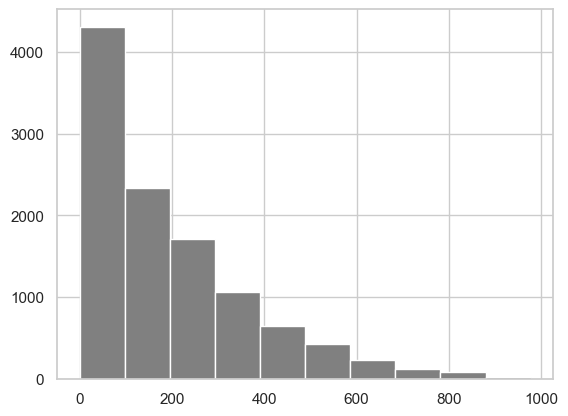

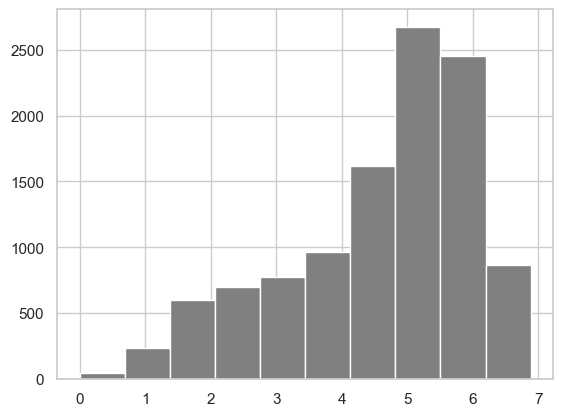

In [110]:
# Plot histogram of count
plt.hist(train['count'], color='grey')
plt.show()

# Plot histogram of log(count+1)
plt.hist(np.log(train['count']+1), color='grey')
plt.show()

# Create new column with log(count+1)
train['log_count'] = np.log(train['count']+1)

# Remove count column
train.drop(columns=['count'], inplace=True)

# 8. Model

## Random Forest

In [112]:
# create hyperparameter grid
mtry = range(9, 31, 2)
node_size = [5, 25, 50]
sample_size = [0.55, 0.632, 0.8]
hyper_grid = list(product(mtry, node_size, sample_size))

# tune hyperparameters using out-of-bag (OOB) RMSE
best_rmse = float('inf')
for m, n, s in hyper_grid:
    rf = RandomForestRegressor(
        n_estimators=100,
        max_features=m,
        min_samples_leaf=n,
        max_samples=s,
        oob_score=True,
        random_state=1108
    )
    rf.fit(train.drop('log_count', axis=1), train['log_count'])
    oob_rmse = mean_squared_error(train['log_count'], rf.oob_prediction_, squared=False)
    if oob_rmse < best_rmse:
        best_rmse = oob_rmse
        best_hyper = (m, n, s)

# fit final model using best hyperparameters
rf_final = RandomForestRegressor(
    n_estimators=100,
    max_features=best_hyper[0],
    min_samples_leaf=best_hyper[1],
    max_samples=best_hyper[2],
    random_state=1108
)
rf_final.fit(train.drop('log_count', axis=1), train['log_count'])

# make predictions on test data and transform back to original count format
yhat_rf = np.exp(rf_final.predict(test)) - 1


RandomForestRegressor(max_features=27, max_samples=0.8, min_samples_leaf=5,
                      random_state=1108)